## Probelm 3

### 3a. Use the FashionMNIST training dataset (which we used in previous assign- ments) to train the DCGAN. Images are grayscale and size 28 × 28.

In [1]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
import random 

torch.Size([1, 28, 28])


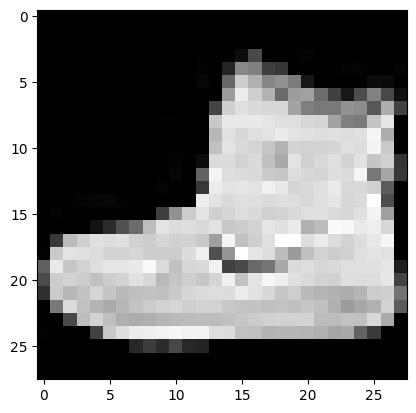

In [3]:
## download the data
train_data = torchvision.datasets.FashionMNIST('./FashionMNIST/',train=True,download=True,transform=torchvision.transforms.ToTensor())
test_data = torchvision.datasets.FashionMNIST('./FashionMNIST/',train=False,download=True,transform=torchvision.transforms.ToTensor())

image, label = train_data[0]
print(image.size())

plt.imshow(image.squeeze(), cmap=plt.cm.gray)


## 3b.

Use the following discriminator architecture (kernel size = 5 × 5 with stride = 2 in both directions):

- 2D convolutions(1×28×28→64×14×14→128×7×7)
- each convolutional layer is equipped with a Leaky ReLU with slope 0.3, followed by Dropout with parameter 0.3.
- a dense layer that takes the flattened output of the last convolution and maps it to a scalar.


In [4]:
import torch
import torch.nn as nn

class Discriminator(nn.Module):
    def __init__(self, input_channels=1):
        super(Discriminator, self).__init__()

        self.conv1 = nn.Conv2d(input_channels, 64, kernel_size=5, stride=2, padding=2)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=5, stride=2, padding=2)

        self.leaky_relu = nn.LeakyReLU(0.3)
        self.dropout = nn.Dropout(0.3)

        self.dense = nn.Linear(128*7*7, 1)  # 128 channels, 7x7 feature map

    def forward(self, x):
        x = self.conv1(x)
        x = self.leaky_relu(x)
        x = self.dropout(x)

        x = self.conv2(x)
        x = self.leaky_relu(x)
        x = self.dropout(x)

        x = torch.flatten(x, 1)

        x = self.dense(x)

        return x


## 2.c

Use the following generator architecture (which is essentially the reverse of a standard discriminative architecture). You can use the same kernel size. Construct:

- a dense layer that takes a unit Gaussian noise vector of length 100 and maps it to a vector of size $(7 \times 7 \times 256)$. No bias terms.
- several transpose 2D convolutions $(256 \times 7 \times 7 \rightarrow 128 \times 7 \times 7 \rightarrow 64 \times 14 \times 14 \rightarrow 1 \times 28 \times 28)$. No bias terms.
- each convolutional layer (except the last one) is equipped with Batch Normalization (batch norm), followed by Leaky ReLU with slope $0.3$. The last (output) layer is equipped with tanh activation (no batch norm).

In [5]:
import torch
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self, input_dim=100, output_channels=1):
        super(Generator, self).__init__()

        self.dense = nn.Linear(input_dim, 7*7*256, bias=False)

        self.conv1 = nn.ConvTranspose2d(256, 128, kernel_size=5, stride=1, padding=2, bias=False)
        self.conv2 = nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2, padding=2, output_padding=1, bias=False)
        self.conv3 = nn.ConvTranspose2d(64, output_channels, kernel_size=5, stride=2, padding=2, output_padding=1, bias=False)

        self.batch_norm1 = nn.BatchNorm2d(128)
        self.batch_norm2 = nn.BatchNorm2d(64)

        self.leaky_relu = nn.LeakyReLU(0.3)

        self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.dense(x)
        x = x.view(-1, 256, 7, 7)  

        x = self.conv1(x)
        x = self.batch_norm1(x)
        x = self.leaky_relu(x)

        x = self.conv2(x)
        x = self.batch_norm2(x)
        x = self.leaky_relu(x)

        x = self.conv3(x)
        x = self.tanh(x)

        return x


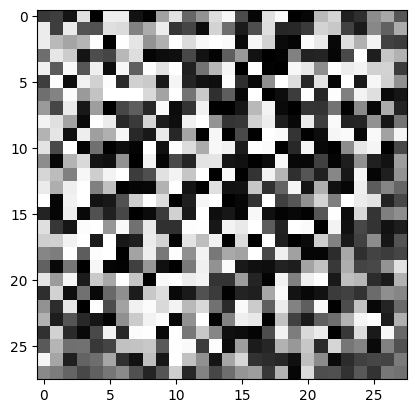

In [6]:
noise_dim = 100

noise = torch.randn(1, noise_dim)
generator = Generator(input_dim=noise_dim, output_channels=1)
generated_image = generator(noise)

random_img = generated_image.detach().numpy()
plt.imshow(random_img.squeeze(), cmap=plt.cm.gray)

## 3d.
Use the binary cross-entropy loss for training both the generator and the discriminator. Use the Adam optimizer with learning rate 10<sup>-4.

In [7]:
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

device = torch.device('cuda:0' if torch.cuda.is_available() else 'mps')

torch.manual_seed(0)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5), (0.5,0.5))
])

batch_size = 64
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)

discriminator = Discriminator().to(device)
generator = Generator(input_dim=noise_dim).to(device)

# Define the loss function (binary cross-entropy)
criterion = nn.BCEWithLogitsLoss().to(device)

# Define the optimizer
lr = 10e-4

d_optimizer = optim.Adam(discriminator.parameters(), lr=lr)
g_optimizer = optim.Adam(generator.parameters(), lr=lr)

## 3e.
Train it for 50 epochs. You can use minibatch sizes of 16, 32, or 64. Training may take several minutes (or even up to an hour), so be patient! Display intermediate images generated after T = 10, T = 30, and T = 50 epochs.

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch [0/50],Discriminator Loss: 0.2978, Generator Loss: 7.8964
Epoch [1/50],Discriminator Loss: 0.2418, Generator Loss: 8.0672
Epoch [2/50],Discriminator Loss: 0.2277, Generator Loss: 6.9869
Epoch [3/50],Discriminator Loss: 0.3562, Generator Loss: 6.8122
Epoch [4/50],Discriminator Loss: 0.1652, Generator Loss: 6.2451
Epoch [5/50],Discriminator Loss: 0.0717, Generator Loss: 6.2053
Epoch [6/50],Discriminator Loss: 0.2070, Generator Loss: 5.3354
Epoch [7/50],Discriminator Loss: 0.2293, Generator Loss: 4.5872
Epoch [8/50],Discriminator Loss: 0.4453, Generator Loss: 5.4327
Epoch [9/50],Discriminator Loss: 0.1583, Generator Loss: 5.6135
Epoch [10/50],Discriminator Loss: 0.2398, Generator Loss: 4.7858
Epoch [11/50],Discriminator Loss: 0.0679, Generator Loss: 7.8822
Epoch [12/50],Discriminator Loss: 0.3442, Generator Loss: 4.7166
Epoch [13/50],Discriminator Loss: 0.2779, Generator Loss: 3.8867
Epoch [14/50],Discriminator Loss: 0.0992, Generator Loss: 7.1785
Epoch [15/50],Discriminator Loss: 0

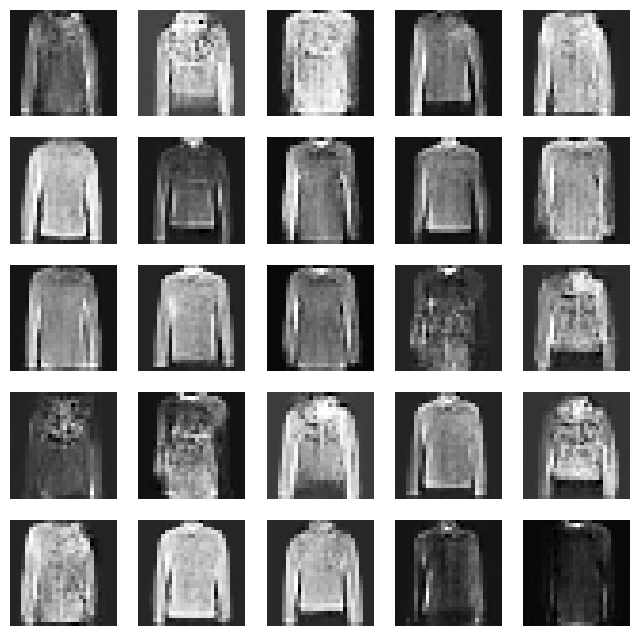

In [13]:
noise_dim = 100
num_epochs = 50

d_loss_history=[]
g_loss_history=[]

for epoch in range(num_epochs):
    for i, (real_images, _) in enumerate(train_loader):
        real_images = real_images.to(device)
        batch_size = real_images.size(0)

        # Train the discriminator
        discriminator.zero_grad()

        # Real images
        real_labels = torch.ones(batch_size, 1).to(device)
        real_output = discriminator(real_images)
        d_loss_real = criterion(real_output, real_labels)

        # Fake images
        noise = torch.randn(batch_size, noise_dim).to(device)
        fake_images = generator(noise)
        fake_labels = torch.zeros(batch_size, 1).to(device)
        fake_output = discriminator(fake_images.detach())
        d_loss_fake = criterion(fake_output, fake_labels)

        # Total discriminator loss
        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        d_optimizer.step()

        # Train the generator
        generator.zero_grad()

        noise = torch.randn(batch_size, noise_dim).to(device)
        fake_images = generator(noise).to(device)
        labels = torch.ones(batch_size, 1).to(device)  # We want the generator to fool the discriminator
        output = discriminator(fake_images).to(device)
        g_loss = criterion(output, labels)
        g_loss.backward()
        g_optimizer.step()


    print(f"Epoch [{epoch}/{num_epochs}],"
    f"Discriminator Loss: {d_loss.item():.4f}, Generator Loss: {g_loss.item():.4f}")

    g_loss_history.append(g_loss.item())
    d_loss_history.append(d_loss.item())

    if epoch % 10 == 0 or epoch == num_epochs-1 :
        plt.figure(figsize=(8, 8))
        generator.eval()
        with torch.no_grad():
            noise = torch.randn(25, noise_dim).to(device)
            generated_images = generator(noise).cpu().detach()
            for i in range(25):
                plt.subplot(5, 5, i + 1)
                plt.imshow(generated_images[i].view(28, 28), cmap='gray')
                plt.axis('off')
        plt.savefig(f'Gen_img_ep_{epoch+1}.png')
        plt.close()

print("Training finished.")

plt.figure(figsize=(8, 8))
generator.eval()
with torch.no_grad():
    noise = torch.randn(25, noise_dim).to(device)
    generated_images = generator(noise).cpu().detach()
    for i in range(25):
        plt.subplot(5, 5, i + 1)
        plt.imshow(generated_images[i].view(28, 28), cmap='gray')
        plt.axis('off')
plt.show()


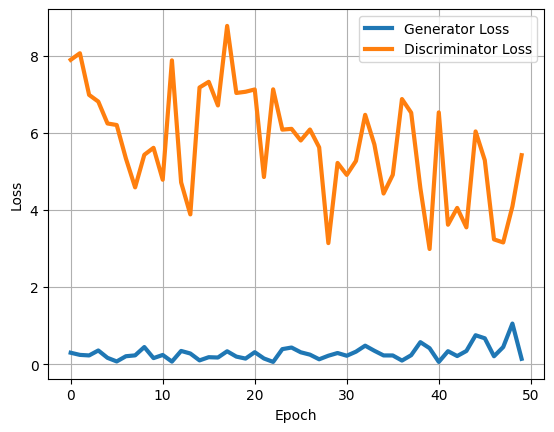

In [17]:
plt.plot(d_loss_history,'-',linewidth=3,label='Generator Loss')
plt.plot(g_loss_history,'-',linewidth=3,label='Discriminator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()